# Integrating a Data Driven PDE

In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.gaussian_process as sk
import tensorflow as tf
import imageio
from tensorflow.keras.layers import Dense, Dropout, Activation
from scipy.integrate import solve_ivp as solve_ivp
from sklearn.gaussian_process.kernels import Matern, RBF,  ConstantKernel
from scipy.interpolate import interp1d as interp1d
from matplotlib import cm
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter1d as gaussian_filter1d
from tensorflow.keras import regularizers
import time

### Import Data

In [2]:
b_0 = np.loadtxt('Data/b.txt')[1:,1:]
bt_0 = np.loadtxt('Data/bt.txt')[1:,1:]
bx_0 = np.loadtxt('Data/bx.txt')[1:,1:]
bxx_0 = np.loadtxt('Data/bxx.txt')[1:,1:]
c_0 = np.loadtxt('Data/c.txt')[1:,1:]
ct_0 = np.loadtxt('Data/ct.txt')[1:,1:]
cx_0 = np.loadtxt('Data/cx.txt')[1:,1:]
cxx_0 = np.loadtxt('Data/cxx.txt')[1:,1:]
r_ar_0 = np.loadtxt('Data/x.txt')[1:,0]
t_ar_0 = np.loadtxt('Data/t.txt')[0,1:]


NR0 = r_ar_0.shape[0]
NT0 = t_ar_0.shape[0]

In [5]:
laplb = np.zeros(b_0.shape)
laplc = np.zeros(c_0.shape)

for i in range(NT0):
    laplb[:,i] = bxx_0[:,i] + bx_0[:,i]/r_ar_0
    laplc[:,i] = cxx_0[:,i] + cx_0[:,i]/r_ar_0

rhs_0 = np.concatenate(([b_0.T], [bx_0.T], [laplb.T], [c_0.T], [cx_0.T], [laplc.T]), axis=0)
rhs_0.shape

rmin, rmax = 1, 500
tmin, tmax = 0, -700
Nr=1
Nt=10

r_ar_1=r_ar_0[rmin:rmax:Nr]
t_ar_1=t_ar_0[tmin:tmax:Nt]

NR1, NT1=r_ar_1.shape[0], t_ar_1.shape[0]


NR0, NT0, NR1, NT1, t_ar_1[-1]

bt_1 = bt_0.T[tmin:tmax:Nt, rmin:rmax:Nr]
ct_1 = ct_0.T[tmin:tmax:Nt, rmin:rmax:Nr]

rhs_1 = rhs_0[:,tmin:tmax:Nt, rmin:rmax:Nr]



### Boundary Conditions

leftbc_b= interp1d(t_ar_0, rhs_0[0,:,rmin-1], kind='linear')
rightbc_b= interp1d(t_ar_0, rhs_0[0,:,rmax], kind='linear')

leftbc_c= interp1d(t_ar_0, rhs_0[3,:,rmin-1], kind='linear')
rightbc_c= interp1d(t_ar_0, rhs_0[3,:,rmax], kind='quadratic')

cp_bt=np.hstack((np.ravel(bt_1)))

cp_rhs= np.reshape(rhs_1, (6, NT1*NR1)).T

cp_rhs.shape, cp_bt.shape

### Normalization

Norm_in=np.copy(cp_rhs)

Norm_in_mu = np.mean(Norm_in, axis=0)

Norm_in_si = np.std(Norm_in, axis=0, ddof=1)

for i in range(6):
    Norm_in[:,i]=(cp_rhs[:,i]-Norm_in_mu[i])/Norm_in_si[i]
        
Norm_out=np.copy(cp_bt)

Norm_out_mu=np.mean(Norm_out)

Norm_out_si=np.std(Norm_out, ddof=1)

Norm_out=(cp_bt-Norm_out_mu)/Norm_out_si

input_data=Norm_in
target_data=Norm_out


input_data.shape, target_data.shape

Norm_out_mu, Norm_out_si, Norm_in_mu, Norm_in_si

uder_model =  tf.keras.models.load_model('BBModel.keras')


def b_to_input_vec(b, c, t, r_array):
    
    dx= np.diff(r_array)[0]
    
    Resx=b.shape[0]

    ders=np.zeros([Resx, 6])
    ders2=np.zeros([Resx, 6])
    
    ders[:,0]=b    
    
    ders[1:-1,1]=(b[2:]-b[:-2])/dx/2
    ders[0,1]=(b[1]-leftbc_b(t))/dx/2
    ders[-1,1]=0
    
    ders[1:-1,2]=(b[2:]-2*b[1:-1]+b[:-2])/dx**2
    ders[0,2]= (b[1]-2*b[0]+leftbc_b(t))/dx**2
    ders[-1,2]= 2*(b[-2]-b[-1])/dx**2
    
    ders[:,3]=c
    
    ders[1:-1,4]=(c[2:]-c[:-2])/dx/2
    ders[0,4]= (c[1]-leftbc_c(t))/2/dx
    ders[-1,4]= (rightbc_c(t)-c[-2])/2/dx
    
    ders[1:-1,5]=(c[2:]-2*c[1:-1]+c[:-2])/dx**2
    ders[0,5]= (c[1]-2*c[0]+leftbc_c(t))/dx**2
    ders[-1,5]= (c[-2]-2*c[-1]+rightbc_c(t))/dx**2
    
    ders1 = np.copy(ders)
    ders1[:,2]= ders[:,2]+ders[:,1]/r_array
    ders1[:,5]= ders[:,5]+ders[:,4]/r_array
    
    for i in range(6):
        ders2[:,i]=(ders1[:,i]-Norm_in_mu[i])/Norm_in_si[i]

    return ders2

def right_hand_side(t,x, r_array):
    
    Nv= int(x.shape[0]/2)
    
    bt_dd=np.zeros(Nv)
    ct_dd=np.zeros(Nv)
    
    b_temp = x[:Nv]
    c_temp = x[Nv:]
        
    c_char = 1
    k = 3000
    D_c=800
        
    input_matrix = b_to_input_vec(b_temp, c_temp, t, r_ar_1)
        
        
    bt_dd = np.ravel(uder_model.predict(np.array(input_matrix),  verbose=0)*Norm_out_si+Norm_out_mu)
    
    dif_norm=input_matrix[:,5]*Norm_in_si[5]+Norm_in_mu[5]
    
    ct_dd = D_c * dif_norm - k * b_temp *  c_temp / (c_temp*10000 + c_char)
    
    
    return np.concatenate((bt_dd , ct_dd))

c:\Users\roshr\miniconda3\envs\jhu_ml_env\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
def Jac22(t, x, r_array):
    
    c_char = 1
    k = 3000
    D_c=800

    Nx = r_array.shape[0]
    
    b, c  = x[:Nx], x[Nx:]
    
    Dx = np.diff(r_array)[0]
        
    DCX =  np.diag(np.ones(Nx-1)/Dx/2, 1) - np.diag(np.ones(Nx-1)/Dx/2, -1)
    
    DCXX =  np.diag(np.ones(Nx-1)/Dx**2, 1) + np.diag(np.ones(Nx-1)/Dx**2, -1)- np.diag(np.ones(Nx)*2/Dx**2)
    
    CM = np.diag(c)
    BM = np.diag(b)
    
    JacC = D_c* DCXX + D_c * DCX/np.array([r_array]).T -  BM * k * c_char / (CM*10000 + c_char)**2
    
    
    return JacC
    
def Jac21(t, x, r_array):
    
    c_char = 1
    k = 3000
    D_c=800

    Nx = r_array.shape[0]
    
    b, c  = x[:Nx], x[Nx:]
        
    CM = np.diag(c)
    
    JacC = - k * CM / (CM*10000 + c_char)
    
    return JacC  


def Jac1(t, x, r_array):
    
    Nx = r_array.shape[0]
    
    b, c  = x[:Nx], x[Nx:]
    
    
    inputs = b_to_input_vec(b, c, t, r_array)
    
    inp = tf.Variable(inputs, dtype=tf.float32)

    with tf.GradientTape() as tape:
        
        preds = uder_model(inp)

    grads = np.asarray(tape.gradient(preds, inp))
    
    
    dNNB = grads[:,0]*(Norm_out_si/Norm_in_si[0])
    dNNBX = grads[:,1]*(Norm_out_si/Norm_in_si[1])
    dNNBXX = grads[:,2]*(Norm_out_si/Norm_in_si[2])
    dNNC = grads[:,3]*(Norm_out_si/Norm_in_si[3])
    dNNCX = grads[:,4]*(Norm_out_si/Norm_in_si[4])
    dNNCXX = grads[:,5]*(Norm_out_si/Norm_in_si[5])
    
    Dx = np.diff(r_array)[0]
        
    DBX =  np.diag(np.ones(Nx-1)/Dx/2, 1) - np.diag(np.ones(Nx-1)/Dx/2, -1)

    DBX[-1,:] *= 0

    DBXX =  np.diag(np.ones(Nx-1)/Dx**2, 1) + np.diag(np.ones(Nx-1)/Dx**2, -1)- np.diag(np.ones(Nx)*2/Dx**2)

    DBXX[-1,-2:] = np.array([2/Dx**2, -2/Dx**2])
    
    DCX =  np.diag(np.ones(Nx-1)/Dx/2, 1) - np.diag(np.ones(Nx-1)/Dx/2, -1)
    
    DCXX =  np.diag(np.ones(Nx-1)/Dx**2, 1) + np.diag(np.ones(Nx-1)/Dx**2, -1)- np.diag(np.ones(Nx)*2/Dx**2)
            
    Jac11 =  np.diag(dNNB) + np.diag(dNNBX) @ DBX + np.diag(dNNBXX) @ (DBXX +  DBX/np.array([r_array]).T)

    Jac12 =  np.diag(dNNC) + np.diag(dNNCX) @ DCX + np.diag(dNNCXX) @ (DCXX +  DBX/np.array([r_array]).T)

    return np.c_[Jac11,Jac12]


def NN_Jacobian(t, x, r_array):
    
    J1 = Jac1(t, x, r_array)
    J21 = Jac21(t, x, r_array)
    J22 = Jac22(t, x, r_array)
    
    J2 = np.c_[J21, J22]
    
    return np.r_[J1, J2]

In [7]:
time_i1 = time.time()

initial_state= np.concatenate((rhs_1[0,0,:], rhs_1[3,0,:]))

sol_dd_1 = solve_ivp(right_hand_side, t_span=(200,290), y0=initial_state, t_eval=np.linspace(200,290, 91),
                  args=(r_ar_1,), method='LSODA', jac=NN_Jacobian).y.T

time_i2 = time.time()

In [8]:
'Time for integration', time_i2-time_i1

('Time for integration', 70.6770236492157)

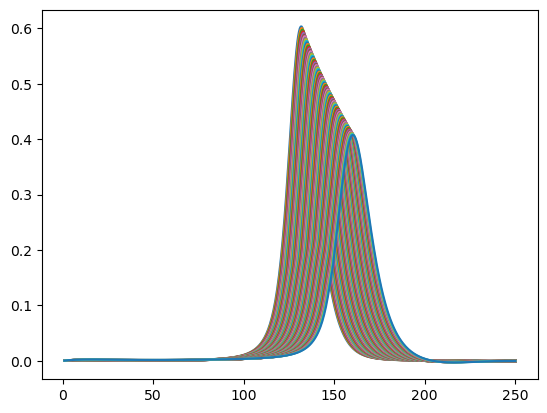

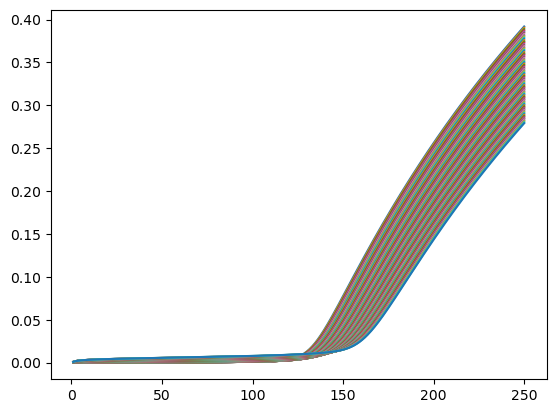

In [11]:
fig, ax = plt.subplots()
# for i in range(7):
for i in range(sol_dd_1.shape[0]):

    ax.plot(r_ar_1, sol_dd_1[i,:NR1])
    
    
fig, ax = plt.subplots()
# for i in range(7):
for i in range(sol_dd_1.shape[0]):

    ax.plot(r_ar_1, sol_dd_1[i,NR1:])

In [10]:
# (pd.DataFrame(sol_dd_1)).to_excel('NNPDEdata.xlsx')